In [1]:
import json
import biosig
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import math
from typing import Literal
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mne.decoding import CSP
from wave_dataloader import MotorImageryDataset, EVENT_TYPES, Util, low_pass_filter, high_pass_filter
import torch
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import tqdm
from torchmetrics.classification import MulticlassPrecision, MulticlassRecall, MulticlassF1Score


In [2]:
EVENT_TYPES = {
    "0x0114" : ("Idling EEG (eyes open)",276, 0),
    "0x0115" : ("Idling EEG (eyes closed)",277, 1),
    "0x0300" : ("Start of a trial",768, 2),
    "0x0301" : ("Cue onset left (class 1)",769, 3),
    "0x0302" : ("Cue onset right (class 2)",770, 4),
    "0x030d" : ("BCI feedback (continuous)",781, 5),
    "0x030f" : ("Cue unknown",783, 6),
    "0x03ff" : ("Rejected trial",1023, 7),
    "0x0430" : ("Eye movements",1072, 8),
    "0x0435" : ("Horizontal eye movement",1077, 9),
    "0x0436" : ("Vertical eye movement",1078, 10),
    "0x0437" : ("Eye rotation",1079, 11),
    "0x0439" : ("Eye blinks",1081, 12),
    "0x7ffe" : ("Start of a new run",32766, 13)
}
device = 'cuda'
SELECT_FEATURES = {
    "0x0430" : 0,
    "0x0435" : 0,
    "0x0436" : 0,
    "0x0437" : 0,
    "0x0439" : 0,
    "0x030d" : 0,
    "0x0301" : 1,
    "0x0302" : 2
}
BATCH_SIZE = 16
SIGNAL_LENGTH = 2000
SAMPLE_RATE = 250
OUTPUT_SIZE = len(SELECT_FEATURES)

In [3]:
trainloader, testloader, (total_length, total_count) = Util.get_data_loader(SELECT_FEATURES, "BCICIV_2b_gdf", n_workers=0, bsz=BATCH_SIZE,shuffle=False, item_length=SIGNAL_LENGTH)
print("Train batchs: ",len(trainloader))
print("Test batchs: ",len(testloader))
print(total_length, total_count , f"{total_length/total_count:.4f}")

(6, 604803)
Train batchs:  7
Test batchs:  1
604803 271 2231.7454


In [4]:
# sample_data = torch.nan_to_num(torch.Tensor(sample_data.T)[0])

# print(sample_data.shape)
# print(sample_data)
# print(high_pass_filter(sample_data, 30, 250))

torch.Size([2000, 6])
torch.Size([2000])
tensor([1.5930, 3.0945, 2.7710,  ..., 0.0000, 0.0000, 0.0000],
       dtype=torch.float64)
tensor(1)


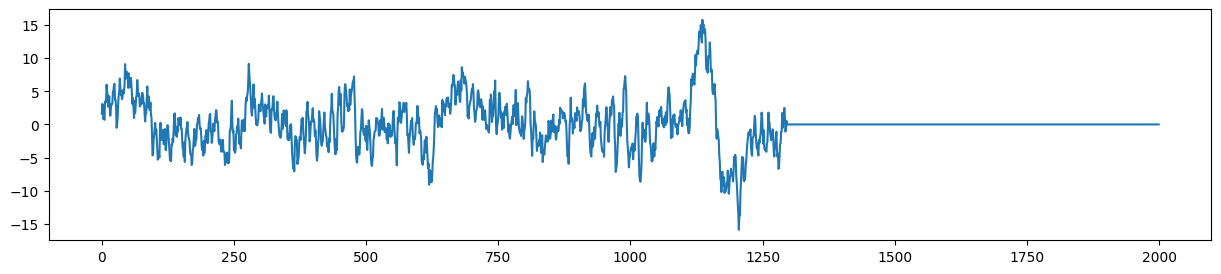

In [5]:
input_sample: torch.Tensor
label_sample: torch.Tensor
skip = 1
for inputs, labels in trainloader:
        input_sample = inputs[0]
        label_sample = labels[0]

print(input_sample.shape)
input_sample = input_sample.T[0]
print(input_sample.shape)
# input_sample = high_pass_filter(input_sample, 0.5, 250, 4)
# input_sample = low_pass_filter(input_sample, 0.5, 250, 4)
plt.figure(figsize=(15,3))
plt.plot(input_sample)
print(input_sample)
print(label_sample)